## **CUPED**

In [52]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats
import seaborn as sns

### Data Generation

In [2]:
def generate_data(sample_size, corr=0.8):
    """Генерируем две выборки с случайным сэмплированием.
    
    sample_size - размер выборки
    corr - корреляция метрики во время эксперимента с метрикой до эксперимента
    
    return - pd.DataFrame со столбцами ['metric', 'metric_before', 'factor'],
        'metric' - значение метрики во время эксперимента,
        'metric_before' - значение метрики до время эксперимента.
    """
    means = [5, 5]
    cov = [[1, corr], [corr, 1]]
    data = np.random.multivariate_normal(means, cov, sample_size)

    # print(data)
    df = pd.DataFrame({'metric': data[:, 0], 'metric_before': data[:, 1]})
    return df

In [3]:
df = generate_data(5, 0.6)
df

,metric,metric_before
0,4.879961,5.161342
1,5.974331,6.270050
2,5.982078,5.291614
3,5.980065,5.271637
4,2.672896,3.895771


In [4]:
df.corr().round(3)

,metric,metric_before
metric,1.000,0.875
metric_before,0.875,1.000


### Evaluation of $\theta$

$$\hat{Y}_{CV} = \overline{Y} - \theta \overline{X} + \theta\mathbb{E}X$$

$$\hat{Y}_{CV, i} = Y_i - \theta X_i + \theta\mathbb{E}X$$

Формула для оптимального значения $\theta$:

$$\theta = \frac{\mathrm{cov}(Y,X)}{\mathbb{V} X}$$


In [5]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    x_control - значения ковариант на контрольной группе
    x_pilot - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    # print(f"cov: {covariance}")
    variance = x.var()
    theta = covariance / variance
    return theta

Посмотрим, как работает функция. Сгенерируем два датасета, к одному из них добавим эффект, вычислим $\theta$.

In [6]:
sample_size = 100
df_control = generate_data(sample_size)
df_pilot = generate_data(sample_size)
df_pilot['metric'] += np.random.normal(0.2, 0.1, sample_size)

# print(df_pilot.head(3))
theta = calculate_theta(
    df_control['metric'], df_pilot['metric'],
    df_control['metric_before'], df_pilot['metric_before']
)
print(f'theta = {theta}')

theta = 0.8154545315362456


Проверим, действительно ли при таком значении $\theta$ достигается минимум дисперсии. 
Для этого вычислим преобразованную метрику и построим график её дисперсии в зависимости от $\theta$ 
для пилотной и контрольной групп.


  0%|          | 0/1000 [00:00<?, ?it/s]

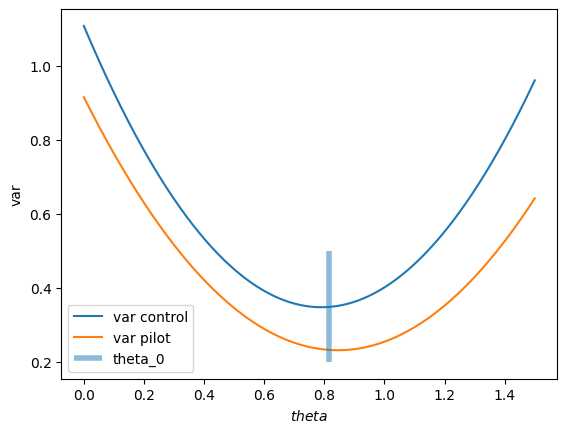

In [7]:
thetas = np.linspace(0, 1.5, 1000)
list_var_control = []
list_var_pilot = []

for theta_ in tqdm(thetas):
    y_cuped_control = df_control['metric'] - theta_ * df_control['metric_before']
    y_cuped_pilot = df_pilot['metric'] - theta_ * df_pilot['metric_before']
    list_var_control.append(y_cuped_control.var())
    list_var_pilot.append(y_cuped_pilot.var())

plt.plot(thetas, list_var_control, label='var control')
plt.plot(thetas, list_var_pilot, label='var pilot')
plt.vlines(theta, 0.2, 0.5, label='theta_0', linewidth=4, alpha=0.5)
plt.xlabel('$theta$')
plt.ylabel('var')
plt.legend()
plt.show()

Действительно, значение $\theta$, найденное по формуле, близко к оптимальным значениям с минимальными дисперсиями.

### Evaluation of Experiments

In [8]:
def check_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних с помощью t-test.

    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return pvalue


def check_cuped_test(df_control, df_pilot, covariate_column):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.

    covariate_column - название стобца с ковариантой

    return - pvalue.
    """
    theta = calculate_theta(
        df_control['metric'], df_pilot['metric'],
        df_control[covariate_column], df_pilot[covariate_column]
    )
    metric_cuped_control = df_control['metric'] - theta * df_control[covariate_column]
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot[covariate_column]
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return pvalue

Посмотрим, как работает `check_cuped_test`. 
Мы создавали пару датафреймов `df_control`, `df_pilot` с наличием эффекта в пилотной группе. 
Применим `check_test` и `check_cuped_test` к этим данным.


In [9]:
pvalue_ttest = check_test(df_control, df_pilot)
pvalue_cuped = check_cuped_test(df_control, df_pilot, 'metric_before')
print(f'pvalue_ttest = {pvalue_ttest:0.3f}')
print(f'pvalue_cuped = {pvalue_cuped:0.3f}')

pvalue_ttest = 0.284
pvalue_cuped = 0.007


**p-value при применении CUPED стало меньше, чувствительность увеличилась**.

#### Evaluation of Probabilities of Type I Errors

Проведём много A/A тестов с различными значениями корреляции целевой метрики и ковариаты, 
затем построим распределение p-value. P-value должно быть распределено равномерно.


  0%|          | 0/1000 [00:00<?, ?it/s]

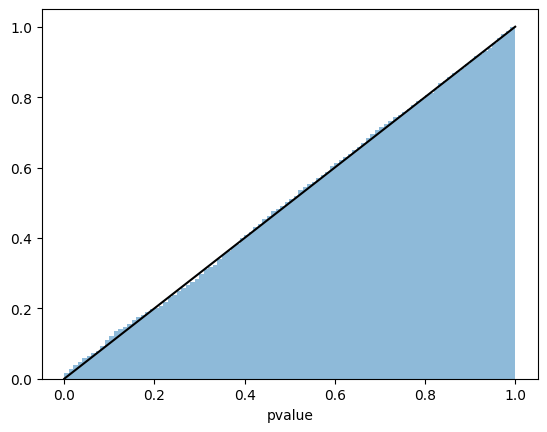

In [10]:
sample_size = 1000
pvalues_cuped = []
corrs = np.random.uniform(-1, 1, 1000)

for corr in tqdm(corrs):
    df_control = generate_data(sample_size, corr)
    df_pilot = generate_data(sample_size, corr)
    pvalues_cuped.append(check_cuped_test(df_control, df_pilot, 'metric_before'))


plt.hist(pvalues_cuped, bins=100, density=True, cumulative=True, alpha=0.5)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.show()

p-value распределено равномерно.

#### Comparing the Experiments' Power

Проведём много синтетических A/B тестов и построим распределение p-value. 
Распределение p-value должно быть выпуклым вверх. Чем более оно выпукло, тем мощнее тест.


  0%|          | 0/1000 [00:00<?, ?it/s]

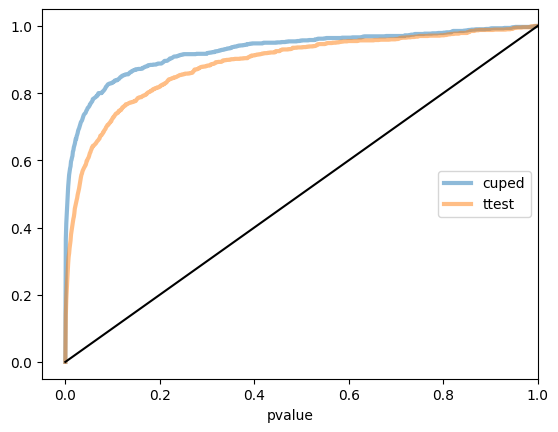

In [11]:
sample_size = 1000
pvalues_ttest = []
pvalues_cuped = []
corrs = np.random.uniform(0.01, 0.99, 1000)

for corr in tqdm(corrs):
    df_control = generate_data(sample_size, corr)
    df_pilot = generate_data(sample_size, corr)
    df_pilot['metric'] += np.random.normal(0.1, 0.01, sample_size)
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped.append(check_cuped_test(df_control, df_pilot, 'metric_before'))


list_pvalues = [pvalues_ttest, pvalues_cuped]
list_titles = ['ttest', 'cuped']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

**Критерий с использованием CUPED обладает большей мощностью**.


### Pizzeria's Data

Рассмотрим пример применения CUPED на данных пиццерии. 
Допустим, мы провели эксперимент на покупателях — высылали письмо с рекламой после покупки. 
В эксперимент попали только те, кто делал покупку во время эксперимента. 
Продолжительность эксперимента — 1 неделя. 
Метрика — средняя выручка с покупателя.

In [ ]:
# загрузка данных
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


df_sales - информация о покупках, одна строка - один заказ. Атрибуты:
- sale_id - идентификатор покупки;
- date - дата покупки;
- count_pizza - количество пицц в заказе;
- count_drink - количество напитков в заказе;
- price - стоимость заказа;
- user_id - идентификатор пользователя;


Вычислим значения метрики и ковариат: 
стоимость покупок за 1 неделю до эксперимента и стоимость покупок за 4 недели до эксперимента.


In [42]:
begin_exp_date = datetime(2022, 3, 21)
end_exp_date = begin_exp_date + timedelta(days=7)

df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_exp_date) & (df_sales['date'] < end_exp_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
)

cov_params = [
    (timedelta(days=7), 'one',),
    (timedelta(days=28), 'two',),
]
for delta, name in cov_params:
    begin_cov_date = begin_exp_date - delta
    df_cov = (
    df_sales
    [(df_sales['date'] >= begin_cov_date) & (df_sales['date'] < begin_exp_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': f'cov_{name}'})
    )
    df_metrics = pd.merge(
      df_metrics,
      df_cov,
      left_index=True,
      right_index=True,
      how='left'
    )
df_metrics.head()

,metric,cov_one,cov_two
user_id,,,
000096,720,NaN,720.0
0000d4,720,NaN,720.0
0000de,660,NaN,660.0
0000e4,840,NaN,840.0
0001e2,2430,NaN,NaN


In [43]:
# доля пропусков в столбцах
df_metrics.isnull().mean()

metric     0.000000
cov_one    0.916514
cov_two    0.246482
dtype: float64

cov_one: выручка за 7 дней до эксперимента (сильно разрежена — 92% пропусков).
cov_two: выручка за 28 дней до — более полная и полезная.

In [44]:
df_metrics.fillna(0, inplace=True)

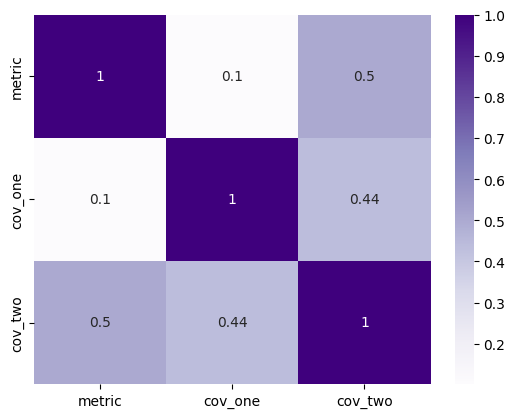

,metric,cov_one,cov_two
metric,1.000000,0.10148,0.503251
cov_one,0.101480,1.00000,0.439640
cov_two,0.503251,0.43964,1.000000


In [93]:
# корреляция
sns.heatmap(df_metrics.corr(), cmap="Purples", annot=True)
plt.show()
df_metrics.corr()

Выберем две группы пользователей размера 10000. 
Добавим небольшой эффект к экспериментальной группе. 
Посмотрим, какие будут значения p-value для разных способов:


In [155]:
control_users, pilot_users = np.random.choice(df_metrics.index, (2, 10000,), False)
df_control = df_metrics.loc[control_users]
df_pilot = df_metrics.loc[pilot_users]
df_pilot['metric'] += 30

print(f'pvalue без CUPED: {check_test(df_control, df_pilot):0.4f}')

for cov_name in ['cov_one', 'cov_two']:
    pvalue = check_cuped_test(df_control, df_pilot, cov_name)
    print(f'pvalue с CUPED ({cov_name}): {pvalue:0.4f}')

pvalue без CUPED: 0.0044
pvalue с CUPED (cov_one): 0.0066
pvalue с CUPED (cov_two): 0.0018


Если позапускать ячейку выше несколько раз, **можно найти ситуации, когда с CUPED получаем p-value больше, чем в обычном t-test**. 
Получается, что **CUPED иногда может приводить к ошибке II рода, когда обычный t-test ошибку бы не допустил**. 
Все статистические тесты могут ошибаться, нам важно, чтобы они в среднем ошибались реже. 
Посмотрим на распределения p-value для разных методов.


  0%|          | 0/1000 [00:00<?, ?it/s]

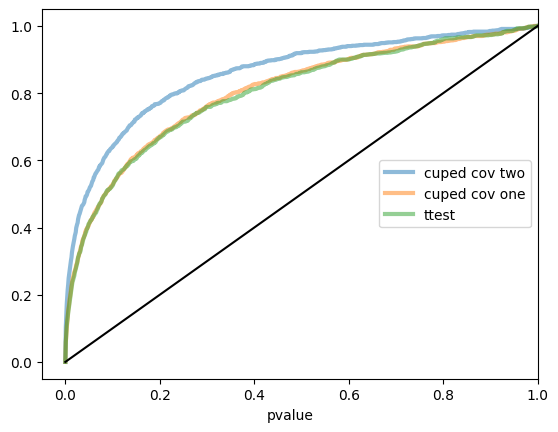

In [49]:
sample_size = 10000
pvalues_ttest = []
pvalues_cuped_cov_one = []
pvalues_cuped_cov_two = []

for corr in tqdm(corrs):
    control_users, pilot_users = np.random.choice(df_metrics.index, (2, sample_size,), False)
    df_control = df_metrics.loc[control_users]
    df_pilot = df_metrics.loc[pilot_users]
    df_pilot['metric'] += 20
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped_cov_one.append(check_cuped_test(df_control, df_pilot, 'cov_one'))
    pvalues_cuped_cov_two.append(check_cuped_test(df_control, df_pilot, 'cov_two'))


list_pvalues = [pvalues_ttest, pvalues_cuped_cov_one, pvalues_cuped_cov_two]
list_titles = ['ttest', 'cuped cov one', 'cuped cov two']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

- CUPED с ковариатой "стоимость покупок за 1 неделю до эксперимента" практически совпадает по мощности с t-test
- CUPED с ковариатой "стоимость покупок за 4 неделю до эксперимента" заметно лучше по мощности чем t-test
- Если ковариата хорошо предсказывает метрику, CUPED даёт ощутимый прирост мощности.

### CUPED + ML

Попробуем построить ковариату с ещё большей корреляцией с помощью алгоритмов машинного обучения.

In [166]:
from lightgbm import LGBMRegressor

def get_features(df, user_ids, date):
    """Генерирует признаки для предсказания.

    Признаки - стоимости покупок по неделям за 4 недели.
    """
    features = [pd.DataFrame(index=user_ids)]
    for delta in range(0, 22, 7):
        date_begin = date - timedelta(delta + 7)
        date_end = date - timedelta(delta)
        features.append(
            df_sales
            [(df_sales['date'] >= date_begin) & (df_sales['date'] < date_end)]
            .groupby('user_id')[['price']].sum()
            .rename(columns={'price': f'delta_{delta}'})
        )
    df_features = pd.concat(features, axis=1).loc[user_ids].fillna(0)
    return df_features

# данные для обучения
df_y_train = (
    df_sales
    [
      (df_sales['date'] >= begin_exp_date - timedelta(7))
      & (df_sales['date'] < end_exp_date - timedelta(7))
    ]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
)
df_x_train = get_features(df_sales, df_y_train.index, begin_exp_date - timedelta(7))
# данные для прогноза
df_x_test = get_features(df_sales, df_metrics.index, begin_exp_date)

**Data**

неделя 1, неделя 2, неделя 3, неделя 4, неделя 5, неделя 6


**Train Data**

признаки (неделя 1, неделя 2, неделя 3, неделя 4) -> прогноз (неделя 5)

**Test data**

признаки (неделя 2, неделя 3, неделя 4, неделя 5) -> прогноз (неделя 6)

In [167]:
# обучение модели
model = LGBMRegressor()
model.fit(df_x_train.values, df_y_train['metric'].values)

# предсказание модели
predict = model.predict(df_x_test.values)

df_metrics['predict'] = predict
df_metrics.corr()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 24815, number of used features: 4
[LightGBM] [Info] Start training from score 1226.003224


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,metric,cov_one,cov_two,predict
metric,1.000000,0.101480,0.503251,0.761580
cov_one,0.101480,1.000000,0.439640,0.155329
cov_two,0.503251,0.439640,1.000000,0.657252
predict,0.761580,0.155329,0.657252,1.000000


In [160]:
df_metrics['predict'].head()

user_id
000096     773.028687
0000d4     773.028687
0000de     702.857149
0000e4     889.388629
0001e2    1247.891826
Name: predict, dtype: float64

Получили **новую ковариату, которая имеет корреляцию больше предыдущих**.

  0%|          | 0/1000 [00:00<?, ?it/s]

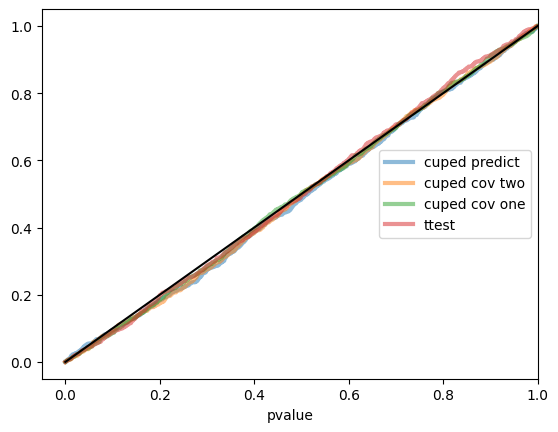

In [161]:
sample_size = 10000
pvalues_ttest = []
pvalues_cuped_cov_one = []
pvalues_cuped_cov_two = []
pvalues_cuped_predict = []

for corr in tqdm(corrs):
    control_users, pilot_users = np.random.choice(df_metrics.index, (2, sample_size,), False)
    df_control = df_metrics.loc[control_users]
    df_pilot = df_metrics.loc[pilot_users]
    df_pilot['metric'] += 0
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped_cov_one.append(check_cuped_test(df_control, df_pilot, 'cov_one'))
    pvalues_cuped_cov_two.append(check_cuped_test(df_control, df_pilot, 'cov_two'))
    pvalues_cuped_predict.append(check_cuped_test(df_control, df_pilot, 'predict'))


list_pvalues = [pvalues_ttest, pvalues_cuped_cov_one, pvalues_cuped_cov_two, pvalues_cuped_predict]
list_titles = ['ttest', 'cuped cov one', 'cuped cov two', 'cuped predict']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

Распределение p-value равномерно для всех вариантов - ошибка 1 рода контролируется

### Оценка эксперимента Sending email (correct link) с использованием CUPED

In [ ]:
# Оценим эксперимент «Sending email (correct link)» с использованием CUPED. 
# В качестве ковариаты используйте выручку пользователей за 4 недели до эксперимента.

# Данные эксперимента «Sending email (correct link)»: 2022-05-03/2022-05-03T12_df_sales.csv и 2022-05-03/experiment_users.csv. 
# Эксперимент проводился с 2022-04-25 по 2022-05-02. Метрика — средняя выручка с клиента.

# загрузка данных
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-05-03/'

def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    x_control - значения ковариант на контрольной группе
    x_pilot - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta

def check_cuped_test(df_control, df_pilot, covariate_column):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.

    covariate_column - название стобца с ковариантой

    return - pvalue.
    """
    theta = calculate_theta(
        df_control['metric'], df_pilot['metric'],
        df_control[covariate_column], df_pilot[covariate_column]
    )
    metric_cuped_control = df_control['metric'] - theta * df_control[covariate_column]
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot[covariate_column]
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return pvalue


def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-05-03T12_df_sales.csv')
df_users = read_database('experiment_users.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Эксперимент проводился с 2022-04-25 по 2022-05-02. Метрика — средняя выручка с клиента.
begin_exp_date = datetime(2022, 4, 25)
end_exp_date = datetime(2022, 5, 2)

begin_cov_date = begin_exp_date - timedelta(days=28)
end_cov_date = begin_exp_date
print('Experiment dates: ',begin_exp_date, end_exp_date)
print('Cov data dates: ', begin_cov_date, end_cov_date)
print('df_sales: \n', df_sales.head(3))
print('df_users: \n', df_users.head(3))

Experiment dates:  2022-04-25 00:00:00 2022-05-02 00:00:00
Cov data dates:  2022-03-28 00:00:00 2022-04-25 00:00:00
df_sales: 
    sale_id                date  count_pizza  count_drink  price user_id
0  1000001 2022-02-04 10:00:24            1            0    720  1c1543
1  1000002 2022-02-04 10:02:28            1            1    930  a9a6e8
2  1000003 2022-02-04 10:02:35            3            1   1980  23420a
df_users: 
   user_id  pilot
0  a9a6e8      0
1  23420a      0
2  cbc468      0


In [205]:
df_metrics = (
    df_sales[(df_sales['date'] >= begin_exp_date) & (df_sales['date'] < end_exp_date)]
    .groupby('user_id')
    .agg(metric = ('price', 'sum'))
    .reset_index()
)
df_cov_metrics = (
    df_sales[(df_sales['date'] >= begin_cov_date) & (df_sales['date'] < end_cov_date)]
    .groupby('user_id')
    .agg(cov = ('price', 'sum'))
    .reset_index()
)
df = df_users.merge(df_metrics, on='user_id', how='left')
df = df.merge(df_cov_metrics, on='user_id', how='left').fillna(0)
print(f'Итоговый dataframe:\n', df.tail(5))
pvalue = check_cuped_test(df[df['pilot'] == 0], df[df['pilot'] == 1], 'cov')
print(f'\n\np-value: {pvalue:.4f}')

Итоговый dataframe:
        user_id  pilot  metric     cov
109362  95b780      1     0.0  2220.0
109363  e8287a      1   720.0   690.0
109364  7f272d      1     0.0   840.0
109365  3cd81f      1   840.0   600.0
109366  a34671      1     0.0  2280.0


p-value: 0.0539


### Метод calculate_metric класса MetricsService

In [ ]:
# Доработаем метод calculate_metric класса MetricsService.


class DataService:

    def __init__(self, table_name_2_table):
        self.table_name_2_table = table_name_2_table

    def get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        df = self.table_name_2_table[table_name]
        if begin_date:
            df = df[df['date'] >= begin_date]
        if end_date:
            df = df[df['date'] < end_date]
        if user_ids:
            df = df[df['user_id'].isin(user_ids)]
        if columns:
            df = df[columns]
        return df.copy()


class MetricsService:

    def __init__(self, data_service):
        """Класс для вычисления метрик.

        :param data_service (DataService): объект класса, предоставляющий доступ с данным.
        """
        self.data_service = data_service

    def _get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        """Возвращает часть таблицы с данными."""
        return self.data_service.get_data_subset(table_name, begin_date, end_date, user_ids, columns)

    def _calculate_revenue_web(self, begin_date, end_date, user_ids):
        """Вычисляет метрику суммарная выручка с пользователя за указанный период
        для заходивших на сайт в указанный период.

        Эта метрика нужна для экспериментов на сайте, когда в эксперимент попадают только те, кто заходил на сайт.
        
        Нужно вернуть значения user_id и суммарной выручки (sum(price)).
        Данный о ценах в таблице 'sales'. Данные о заходивших на сайт в таблице 'web-logs'.
        Если пользователь зашёл на сайт и ничего не купил, его суммарная стоимость покупок равна нулю.
        Для каждого user_id должно быть ровно одно значение.

        :param begin_date, end_date (datetime): период времени, за который нужно считать метрику.
            Также за этот период времени нужно выбирать пользователей, которые заходили на сайт.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        user_ids_ = (
            self._get_data_subset('web-logs', begin_date, end_date, user_ids, ['user_id'])
            ['user_id'].unique()
        )
        df = (
            self._get_data_subset('sales', begin_date, end_date, user_ids, ['user_id', 'price'])
            .groupby('user_id')[['price']].sum().reset_index() 
            .rename(columns={'price': 'metric'})
        )
        df = pd.merge(pd.DataFrame({'user_id': user_ids_}), df, on='user_id', how='left').fillna(0)
        return df[['user_id', 'metric']]

    @staticmethod
    def _calculate_cuped_theta(y, y_cov) -> float:
        """Вычисляем Theta.

        y - значения метрики во время пилота
        y_cov - значения ковариант
        """
        covariance = np.cov(y_cov, y)[0, 1]
        variance = y_cov.var()
        theta = covariance / variance
        return theta

    def _calculate_cuped_metric(self, df) -> pd.Series:
        """Вычисляем столбец с CUPED метрикой.

        :param df: датафрейм с метриками, columns = ['user_id', 'metric', 'metric_cov']
        """
        y = df['metric'].values
        y_cov = df['metric_cov'].values
        theta = self._calculate_cuped_theta(y, y_cov)
        return df['metric'] - theta * (df['metric_cov'] - df['metric_cov'].mean())  # с учетом централизации (когда CUPED как метрика новая)

    def calculate_metric(self, metric_name, begin_date, end_date, cuped, user_ids=None):
        """Считает значения метрики.

        :param metric_name (str): название метрики
        :param begin_date (datetime): дата начала периода (включая границу)
        :param end_date (datetime): дата окончания периода (не включая границу)
        :param cuped (str): применение CUPED. ['off', 'on (previous week revenue)']
            'off' - не применять CUPED
            'on (previous week revenue)' - применяем CUPED, в качестве ковариаты
                используем выручку за прошлую неделю
        :param user_ids (list[str], None): список пользователей.
            Если None, то вычисляет метрику для всех пользователей.
        :return df: columns=['user_id', 'metric']
        """
        if metric_name == 'revenue (web)':
            if cuped == 'off':
                return self._calculate_revenue_web(begin_date, end_date, user_ids)
            elif cuped == 'on (previous week revenue)':
                df = self._calculate_revenue_web(begin_date, end_date, user_ids)
                begin_date_cov, end_date_cov = begin_date - timedelta(days=7), begin_date
                df_cov = (
                    self._calculate_revenue_web(begin_date_cov, end_date_cov, user_ids)
                    .rename(columns={'metric': 'metric_cov'})
                )
                df = pd.merge(df, df_cov, on='user_id', how='left').fillna(0)
                df['metric'] = self._calculate_cuped_metric(df)
                return df[['user_id', 'metric']]
            else:
                raise ValueError('Wrong cuped')
        else:
            raise ValueError('Wrong metric name')


def _chech_df(df, df_ideal, sort_by, reindex=False, set_dtypes=False, decimal=None):
    assert isinstance(df, pd.DataFrame), 'Функция вернула не pd.DataFrame.'
    assert len(df) == len(df_ideal), 'Неверное количество строк.'
    assert len(df.T) == len(df_ideal.T), 'Неверное количество столбцов.'
    columns = df_ideal.columns
    assert df.columns.isin(columns).sum() == len(df.columns), 'Неверное название столбцов.'
    df = df[columns].sort_values(sort_by)
    df_ideal = df_ideal.sort_values(sort_by)
    if reindex:
        df_ideal.index = range(len(df_ideal))
        df.index = range(len(df))
    if set_dtypes:
        for column, dtype in df_ideal.dtypes.to_dict().items():
            df[column] = df[column].astype(dtype)
    if decimal:
        ideal_values = df_ideal.astype(float).values
        values = df.astype(float).values
        np.testing.assert_almost_equal(ideal_values, values, decimal=decimal)
    else:
        assert df_ideal.equals(df), 'Итоговый датафрейм не совпадает с верным результатом.'


if __name__ == '__main__':
    df_sales = pd.DataFrame({
        'sale_id': [1, 2, 3, 4, 5],
        'date': [datetime(2022, 3, day, 11) for day in range(10, 15)],
        'price': [1100, 1500, 2000, 2500, 3000],
        'user_id': ['1', '2', '1', '2', '3'],
    })
    df_web_logs = pd.DataFrame({
        'date': [datetime(2022, 3, day, 11) for day in range(10, 15)],
        'user_id': ['1', '2', '1', '2', '3'],
    })
    begin_date = datetime(2022, 3, 12, 0)
    end_date = datetime(2022, 3, 19, 0)

    ideal_metrics = pd.DataFrame({
        'user_id': ['1', '2', '3'],
        'metric': [2159.5303, 2933.0110, 2407.45856],
    })

    data_service = DataService({'sales': df_sales, 'web-logs': df_web_logs})
    metrics_service = MetricsService(data_service)
    metrics = metrics_service.calculate_metric(
        'revenue (web)', begin_date, end_date, 'on (previous week revenue)'
    )
    _chech_df(metrics, ideal_metrics, ['user_id', 'metric'], True, True, decimal=1)
    print('simple test passed')


simple test passed
